In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import gpib
import time
import tqdm

In [ ]:
class YokogawaGS200(object):
	def __init__(self, gpib, addr):
		self.gpib = gpib
		self.addr = addr
		
		self.gpib.addr(self.addr)
		id = self.gpib('*idn?', True)
		if not id.startswith('YOKOGAWA,GS2'):
			raise ValueError('Device identifies as ' + id)

	def output(self, on):
		self.gpib.addr(self.addr)
		if on:
			self.gpib(':OUTP 1')
		else:
			self.gpib(':OUTP 0')

	def voltage_mode(self):
		self.gpib.addr(self.addr)
		self.gpib(':SOUR:FUNC VOLT')

	def current_mode(self):
		self.gpib.addr(self.addr)
		self.gpib(':SOUR:FUNC CURR')

	def set_range(self, range):
		''' Valid values are .001, .01, .1, .2, 1, 10, 30 '''
		self.gpib.addr(self.addr)

		if range < 1:
			self.gpib(':SOUR:RANG %dE-3' % (range*1000))
		else:
			self.gpib(':SOUR:RANG %dE+0' % range)

		newrange = self.gpib(':SOUR:RANG?', True)
		if float(newrange) != range:
			raise ValueError('GS200 did not accept request for range %f, returned %s' % (range, newrange))
		return newrange

	def set_level(self, level):
		self.gpib.addr(self.addr)
		self.gpib(':SOUR:LEV %f' % level)

class Keysight34420A(object):
	def __init__(self, gpib, addr):
		self.gpib = gpib
		self.addr = addr
		
		self.gpib.addr(self.addr)
		id = self.gpib('*idn?', True)
		if not id.startswith('HEWLETT-PACKARD,34420A'):
			raise ValueError('Device identifies as ' + id)

	def get_value(self, range='AUTO', channel=1):
		''' Gets the value before this command, then triggers an update for the next call '''
		self.gpib.addr(23)
		return float(self.gpib('MEAS:VOLT:DC? %s,(@%d)' % (range, channel), True))

class Kiethley196(object):
	def __init__(self, gpib, addr):
		self.gpib = gpib
		self.addr = addr
		
		self.gpib.addr(self.addr)
		id = self.gpib('', True)
		if not id.startswith('N'):
			raise ValueError('Unexpected device response ' + id)

	def dc_volts(self):
		self.gpib.addr(self.addr)
		self.gpib('F0X', True)
	def ac_volts(self):
		self.gpib.addr(self.addr)
		self.gpib('F1X', True)
	def dc_amps(self):
		self.gpib.addr(self.addr)
		self.gpib('F3X', True)
	def ac_amps(self):
		self.gpib.addr(self.addr)
		self.gpib('F4X', True)
	def ohms(self):
		self.gpib.addr(self.addr)
		self.gpib('F2X', True)
	def range(self, range):
		'''Set range to a value in 0-7. 0 is AUTO, while higher numbers are 3 * 10^(x0 + range), with x0 = -4 for voltages, -7 for current, and +1 for resistance. '''
		self.gpib.addr(self.addr)
		self.gpib('F%dX' % range, True)
	def get_value(self):
		self.gpib.addr(self.addr)
		rval = self.gpib('', True)
		bk = rval.find('+')
		if bk < 0 or (0 < rval.find('-') < bk):
			bk = rval.find('-')
		return (float(rval[bk:]), rval[1:bk])

gpibint = gpib.PrologixGPIB('COM3')
yk = YokogawaGS200(gpibint, 1) # POWER SUPPLY
dvm = Keysight34420A(gpibint, 23) # VOLT METER
dmm = Kiethley196(gpibint, 9) # 2ND VOLT METER
yk.current_mode()
yk.set_range(.1)
yk.set_level(0.0)
yk.output(True)

In [16]:
def measure_current(current_mA, sleep_time=0.1):
    yk.set_level(current_mA / 1000.0)
    time.sleep(sleep_time)
    try:
        return dvm.get_value(channel=1)
    except:
        print('Error reading DVM')
        return None
    finally:
        yk.set_level(0.0)

  3%|▎         | 1/30 [00:01<00:32,  1.11s/it]

Error reading DVM


  7%|▋         | 2/30 [00:02<00:31,  1.11s/it]

Error reading DVM


 10%|█         | 3/30 [00:03<00:29,  1.11s/it]

Error reading DVM


 13%|█▎        | 4/30 [00:04<00:28,  1.11s/it]

Error reading DVM


 17%|█▋        | 5/30 [00:05<00:27,  1.11s/it]

Error reading DVM


 20%|██        | 6/30 [00:06<00:26,  1.12s/it]

Error reading DVM


 23%|██▎       | 7/30 [00:07<00:25,  1.11s/it]

Error reading DVM


 27%|██▋       | 8/30 [00:08<00:24,  1.11s/it]

Error reading DVM


 30%|███       | 9/30 [00:10<00:23,  1.11s/it]

Error reading DVM


 33%|███▎      | 10/30 [00:11<00:22,  1.12s/it]

Error reading DVM


100%|██████████| 30/30 [00:26<00:00,  1.15it/s]


Text(0.5, 1.0, 'IV Curve')

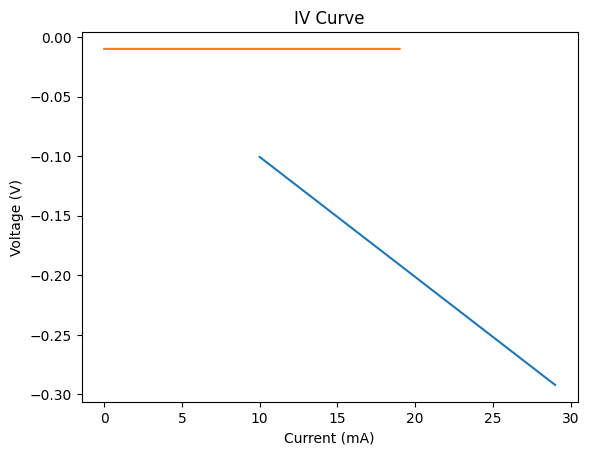

In [28]:
IVR = []
for i in tqdm.trange(0, 30, 1):
    v = measure_current(i)
    if v is not None:
        IVR.append((i, v, v/i))

plt.plot(*zip(*IVR))
plt.xlabel('Current (mA)')
plt.ylabel('Voltage (V)')
plt.title('IV Curve')

Text(0, 0.5, 'Resistance (Ohm)')

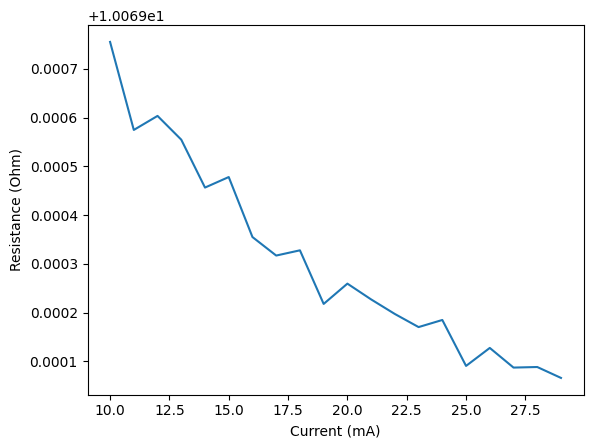

In [29]:
I, V, R = zip(*IVR)
plt.plot(I, np.array(R)*-1000)
plt.xlabel('Current (mA)')
plt.ylabel('Resistance (Ohm)')